# COVID-19: Predicting the Spread of Coronavirus

### A Data Science Project by:
### Ronald DeLuca & Lulu Melhem
#### March 10th, 2020

In [1]:
import pandas as pd
import numpy as np 
import re
import glob
import datetime
from math import sqrt
from matplotlib import pyplot as plt
import matplotlib.dates as dates
from matplotlib.dates import DateFormatter
#import matplotlib.ticker as mticker
#import mplfinance as mpf
import plotly.graph_objects as go
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import median_absolute_error, r2_score, mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance, mean_tweedie_deviance, max_error
from sklearn.metrics import explained_variance_score
from IPython.display import HTML, display
import tabulate
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [2]:
# Read all CSVs from data/ folder, preprocess columns and inject Dates from filename
# Concatenate all CSVs into one dataframe, ensuring different formats align correctly.
all_files = glob.glob('./data' + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df.rename(columns={'Country/Region':'Country'}, inplace=True)
    df.rename(columns={'Country_Region':'Country'}, inplace=True)
    df.rename(columns={'Province/State':'Province_State'}, inplace=True)
    df.rename(columns={'Last Update':'Last_Update'}, inplace=True)
    df.rename(columns={'Admin2':'City'}, inplace=True)
    df.rename(columns={'Lat':'Latitude'}, inplace=True)
    df.rename(columns={'Long_':'Longitude'}, inplace=True)
    dateRe = re.search("([0-9]{2}\-[0-9]{2}\-[0-9]{4})", filename)
    #print(dateRe.group(1))
    df['Date'] = dateRe.group(1)
    li.append(df)

covidCompiled = pd.concat(li, axis=0, ignore_index=True)
covidCompiled = covidCompiled[['Date', 'Last_Update', 'Province_State', 'Country', 'Confirmed', 'Deaths', 'Recovered', 
        'Active', 'Latitude', 'Longitude', 'FIPS', 'City', 'Combined_Key']]
values = {'Confirmed': 0, 'Deaths': 0, 'Recovered': 0, 'Active': 0}
covidCompiled.fillna(value=values, inplace=True)
covidCompiled['Last_Update'] =pd.to_datetime(covidCompiled.Last_Update)
covidCompiled['Confirmed'] =pd.to_numeric(covidCompiled.Confirmed)
covidCompiled['Deaths'] =pd.to_numeric(covidCompiled.Deaths)
covidCompiled['Recovered'] =pd.to_numeric(covidCompiled.Recovered)
covidCompiled['Active'] =pd.to_numeric(covidCompiled.Active)
covidCompiled = covidCompiled.sort_values(['Last_Update'], ascending=(True))
covidCompiled = covidCompiled.reset_index(drop=True)
#covidCompiled['Date'] = covidCompiled['Last_Update'].values
covidCompiled['Date'] = pd.to_datetime(covidCompiled['Date']).dt.date
#cols = covidCompiled.columns.tolist()
#cols = cols[-1:] + cols[:-1]
#covidCompiled = covidCompiled[cols]
covidCompiled.to_csv('covidCompiled.csv')
covidCompiled

,Date,Last_Update,Province_State,Country,Confirmed,Deaths,Recovered,Active,Latitude,Longitude,FIPS,City,Combined_Key
0,2020-01-22,2020-01-22 17:00:00,Qinghai,Mainland China,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,2020-01-22,2020-01-22 17:00:00,Inner Mongolia,Mainland China,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2020-01-22,2020-01-22 17:00:00,Hunan,Mainland China,4.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,2020-01-22,2020-01-22 17:00:00,Hubei,Mainland China,444.0,17.0,28.0,0.0,NaN,NaN,NaN,NaN,NaN
4,2020-01-22,2020-01-22 17:00:00,Hong Kong,Hong Kong,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28131,2020-03-27,2020-03-27 23:27:48,South Australia,Australia,257.0,0.0,6.0,251.0,-34.9285,138.6007,NaN,NaN,"South Australia, Australia"
28132,2020-03-27,2020-03-27 23:27:48,Tasmania,Australia,47.0,0.0,3.0,44.0,-42.8821,147.3272,NaN,NaN,"Tasmania, Australia"
28133,2020-03-27,2020-03-27 23:27:48,Victoria,Australia,574.0,3.0,171.0,400.0,-37.8136,144.9631,NaN,NaN,"Victoria, Australia"
28134,2020-03-27,2020-03-27 23:27:48,New South Wales,Australia,1405.0,7.0,4.0,1394.0,-33.8688,151.2093,NaN,NaN,"New South Wales, Australia"


In [3]:
# Use compiled df to fill in missing values in older CSVs through searching
#count = 0;
covidFilled = covidCompiled
for row in covidFilled.itertuples():
    if row[13] != row[13]:
        if row[3] != row[3]:
            covidFilled.at[row[0], 'Combined_Key'] = row[4]
        else:
            covidFilled.at[row[0], 'Combined_Key'] = row[3] + ', ' + row[4]
    if row[9] != row[9]:
        found = covidFilled.loc[(covidFilled['Province_State'] == row[3]) & 
                (covidFilled['Latitude'] == covidFilled['Latitude'])]
        if 0 < len(found.values):
            covidFilled.at[row[0], 'Latitude'] = found.values[0][8]
        else:
            newfound = covidFilled.loc[(covidFilled['Country'] == row[4]) & 
                (covidFilled['Latitude'] == covidFilled['Latitude'])]
            if 0 < len(newfound.values):
                covidFilled.at[row[0], 'Latitude'] = newfound.values[0][8]
    if row[10] != row[10]:
        found = covidFilled.loc[(covidFilled['Province_State'] == row[3]) & 
                (covidFilled['Longitude'] == covidFilled['Longitude'])]
        if 0 < len(found.values):
            covidFilled.at[row[0], 'Longitude'] = found.values[0][9]
        else:
            newfound = covidFilled.loc[(covidFilled['Country'] == row[4]) & 
                (covidFilled['Longitude'] == covidFilled['Longitude'])]
            if 0 < len(newfound.values):
                covidFilled.at[row[0], 'Longitude'] = newfound.values[0][9]

for row in covidFilled.itertuples():
    if row[12] != row[12]:
        cityFound = covidFilled.loc[(covidFilled['Latitude'] == row[9]) & 
                (covidFilled['Longitude'] == row[10]) & 
                (covidFilled['City'] == covidFilled['City'])]
        if 0 < len(cityFound.values):
            covidFilled.at[row[0], 'City'] = cityFound.values[0][11]
    if row[11] != row[11]:
        fipsfound = covidFilled.loc[(covidFilled['Latitude'] == row[9]) & 
                (covidFilled['Longitude'] == row[10]) & 
                (covidFilled['FIPS'] == covidFilled['FIPS'])]
        if 0 < len(fipsfound.values):
                covidFilled.at[row[0], 'FIPS'] = fipsfound.values[0][10]
        else:
            newfipsfound = covidFilled.loc[(covidFilled['City'] == row[12]) & 
                (covidFilled['FIPS'] == covidFilled['FIPS'])]
            if 0 < len(newfipsfound.values):
                covidFilled.at[row[0], 'FIPS'] = newfipsfound.values[0][10]

    #count += 1
covidFilled.to_csv('covidFilled.csv')
covidFilled

,Date,Last_Update,Province_State,Country,Confirmed,Deaths,Recovered,Active,Latitude,Longitude,FIPS,City,Combined_Key
0,2020-01-22,2020-01-22 17:00:00,Qinghai,Mainland China,0.0,0.0,0.0,0.0,35.7452,95.9956,NaN,NaN,"Qinghai, Mainland China"
1,2020-01-22,2020-01-22 17:00:00,Inner Mongolia,Mainland China,0.0,0.0,0.0,0.0,44.0935,113.9448,NaN,NaN,"Inner Mongolia, Mainland China"
2,2020-01-22,2020-01-22 17:00:00,Hunan,Mainland China,4.0,0.0,0.0,0.0,27.6104,111.7088,NaN,NaN,"Hunan, Mainland China"
3,2020-01-22,2020-01-22 17:00:00,Hubei,Mainland China,444.0,17.0,28.0,0.0,30.9756,112.2707,NaN,NaN,"Hubei, Mainland China"
4,2020-01-22,2020-01-22 17:00:00,Hong Kong,Hong Kong,0.0,0.0,0.0,0.0,22.3000,114.2000,NaN,NaN,"Hong Kong, Hong Kong"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28131,2020-03-27,2020-03-27 23:27:48,South Australia,Australia,257.0,0.0,6.0,251.0,-34.9285,138.6007,NaN,NaN,"South Australia, Australia"
28132,2020-03-27,2020-03-27 23:27:48,Tasmania,Australia,47.0,0.0,3.0,44.0,-42.8821,147.3272,NaN,NaN,"Tasmania, Australia"
28133,2020-03-27,2020-03-27 23:27:48,Victoria,Australia,574.0,3.0,171.0,400.0,-37.8136,144.9631,NaN,NaN,"Victoria, Australia"
28134,2020-03-27,2020-03-27 23:27:48,New South Wales,Australia,1405.0,7.0,4.0,1394.0,-33.8688,151.2093,NaN,NaN,"New South Wales, Australia"


In [4]:
# Simplified Johns Hopkins CSVs pulled here to verify numbers against.
#confirmedUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
confirmedUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
#deathsUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
deathsUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
#recoveredUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
recoveredUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
#covidCompiled = './covid_19_data.csv'
df_confirmed = pd.read_csv(confirmedUrlTs)
df_deaths = pd.read_csv(deathsUrlTs)
df_recovered = pd.read_csv(recoveredUrlTs)
#df_compiled = pd.read_csv(covidCompiled, parse_dates=['Last Update'])

df_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
df_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
df_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)
#df_compiled.rename(columns={'ObservationDate':'Date', 'Country/Region':'Country'}, inplace=True)
#df_confirmed.head()

In [5]:
count = 0
upper = 1
new_df = pd.DataFrame()
for row in df_confirmed.itertuples():
    count += 1
    upper += 1
    if upper < len(df_confirmed.index):
        confir = df_confirmed[count:upper].T
        confir.insert(0, "ProvinceState", confir.values[0][0])
        confir.insert(1, "Country", confir.values[1][1])
        confir.insert(2, "Lat", confir.values[2][2])
        confir.insert(3, "Long", confir.values[3][3])
        confir.columns.values[4] = 'Confirmed'
        confirm = confir[4:]

        deat = df_deaths[count:upper].T
        death = deat[4:]
        #recov = df_recovered[count:upper].T
        #recove = recov[4:]

        compl = pd.concat([confirm, death], axis=1)
        #compl = pd.concat([confirm, death, recove], axis=1)
        compl.columns.values[5] = 'Deaths'
        #compl.columns.values[6] = 'Recovered'
        new_df = pd.concat([new_df, compl])
    elif upper == len(df_confirmed.index):
        confir = df_confirmed[-1:].T
        confir.insert(0, "ProvinceState", confir.values[0][0])
        confir.insert(1, "Country", confir.values[1][1])
        confir.insert(2, "Lat", confir.values[2][2])
        confir.insert(3, "Long", confir.values[3][3])
        confir.columns.values[4] = 'Confirmed'
        confirm = confir[4:]

        deat = df_deaths[-1:].T
        death = deat[4:]
        #recov = df_recovered[-1:].T
        #recove = recov[4:]

        compl = pd.concat([confirm, death], axis=1)
        #compl = pd.concat([confirm, death, recove], axis=1)
        compl.columns.values[5] = 'Deaths'
        #compl.columns.values[6] = 'Recovered'
        new_df = pd.concat([new_df, compl])
    else:
        confir = df_confirmed[:1].T
        confir.insert(0, "ProvinceState", confir.values[0][0])
        confir.insert(1, "Country", confir.values[1][1])
        confir.insert(2, "Lat", confir.values[2][2])
        confir.insert(3, "Long", confir.values[3][3])
        confir.columns.values[4] = 'Confirmed'
        confirm = confir[4:]

        deat = df_deaths[:1].T
        death = deat[4:]
        #recov = df_recovered[:1].T
        #recove = recov[4:]

        compl = pd.concat([confirm, death], axis=1)
        #compl = pd.concat([confirm, death, recove], axis=1)
        compl.columns.values[5] = 'Deaths'
        #compl.columns.values[6] = 'Recovered'
        new_df = pd.concat([new_df, compl])
        

print (count)
new_df.sort_index()
new_df['Date'] = new_df.index
cols = new_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
new_df = new_df[cols]
new_df['Date'] =pd.to_datetime(new_df.Date)
new_df['Confirmed'] =pd.to_numeric(new_df.Confirmed)
new_df['Deaths'] =pd.to_numeric(new_df.Deaths)
#new_df['Recovered'] =pd.to_numeric(new_df.Recovered)
new_df = new_df.sort_values(['Date', 'Country'], ascending=(True, True))
new_df = new_df.reset_index(drop=True)
covidFull = new_df
#covidFull.dtypes
covidFull.to_csv('basicCovid.csv')
#covidFull

249


In [6]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
datesGroup = covidFilled.groupby('Date').sum()[['Confirmed', 'Deaths', 'Recovered']].reset_index()
datesGroup.to_csv('datesGroup.csv')
days_range = np.array([i for i in range(len(datesGroup))]).reshape(-1, 1)
future_range = np.array([i for i in range(len(datesGroup)+10)]).reshape(-1, 1)
adjusted_dates = future_range[:-10]
start_date = datetime.datetime.strptime('2020-01-22', '%Y-%m-%d')
start_short = datetime.datetime.strptime('01-22', '%m-%d')
future_range_dates = []
future_range_dates_short = []
for i in range(len(future_range)):
    future_range_dates.append((start_date + datetime.timedelta(days=i)).strftime('%Y-%m-%d'))
    future_range_dates_short.append((start_short + datetime.timedelta(days=i)).strftime('%m-%d'))
world_confirmed = datesGroup['Confirmed'].to_numpy()

In [8]:
X_train_world_confirmed, X_test_world_confirmed, y_train_world_confirmed, y_test_world_confirmed = \
train_test_split(days_range, world_confirmed, test_size=0.15, shuffle=False)

## Linear Regression

In [9]:
## World Linear Regression
linear_reg_model = LinearRegression(normalize=True, fit_intercept=False)
linear_reg_model.fit(X_train_world_confirmed, y_train_world_confirmed)
test_linear_world_conf_pred = linear_reg_model.predict(X_test_world_confirmed)
linear_world_conf_pred = linear_reg_model.predict(future_range)
mAE_linear_world_conf = mean_absolute_error(y_test_world_confirmed, test_linear_world_conf_pred)
mSE_linear_world_conf = mean_squared_error(y_test_world_confirmed, test_linear_world_conf_pred)
mSLE_linear_world_conf = mean_squared_log_error(y_test_world_confirmed, test_linear_world_conf_pred)
rMSE_linear_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_linear_world_conf_pred))
mAbE_linear_world_conf = median_absolute_error(y_test_world_confirmed, test_linear_world_conf_pred)
mAPE_linear_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_linear_world_conf_pred)
r2_linear_world_conf = r2_score(y_test_world_confirmed, test_linear_world_conf_pred)
mPD_linear_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_linear_world_conf_pred)
mGD_linear_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_linear_world_conf_pred)
mTD_linear_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_linear_world_conf_pred)
mE_linear_world_conf = max_error(y_test_world_confirmed, test_linear_world_conf_pred)
mEVS_linear_world_conf = explained_variance_score(y_test_world_confirmed, test_linear_world_conf_pred)

print('Linear Regression on Worldwide Confirmed Cases: ')
print('Mean Absolute Error:', mAE_linear_world_conf)
print('Mean Squared Error:', mSE_linear_world_conf)
print('Mean Squared Log Error:', mSLE_linear_world_conf)
print('Root Mean Squared Error:', rMSE_linear_world_conf)
print('Media Absolute Error:', mAbE_linear_world_conf)
print('Mean Absolute Percentage Error:', mAPE_linear_world_conf)
print('R2 Score:', r2_linear_world_conf)
print('Mean Poisson Deviance:', mPD_linear_world_conf)
print('Mean Gamma Deviance:', mGD_linear_world_conf)
print('Medan Tweedie Deviance:', mTD_linear_world_conf)
print('Max Error:', mE_linear_world_conf)
print('Explained Variance Score:', mEVS_linear_world_conf)

Linear Regression on Worldwide Confirmed Cases: 
Mean Absolute Error: 218712.88194980705
Mean Squared Error: 60340849307.69255
Mean Squared Log Error: 0.7509583699548251
Root Mean Squared Error: 245643.74469481723
Media Absolute Error: 200559.18194980704
Mean Absolute Percentage Error: 54.429131035271915
R2 Score: -3.246848769763722
Mean Poisson Deviance: 245205.50220994372
Mean Gamma Deviance: 1.0788549035028285
Medan Tweedie Deviance: 60340849307.69255
Max Error: 424511.9806072307
Explained Variance Score: 0.11984878777804941


In [10]:
linear_world_conf_pred = linear_world_conf_pred.reshape(1,-1)[0]
print('Linear Regression Worldwide Confirmed Cases Future Predictions: ')
set(zip(future_range_dates[-10:], np.round(linear_world_conf_pred[-10:])))

Linear Regression Worldwide Confirmed Cases Future Predictions: 


{('2020-03-28', 171376.0),
 ('2020-03-29', 173972.0),
 ('2020-03-30', 176569.0),
 ('2020-03-31', 179165.0),
 ('2020-04-01', 181762.0),
 ('2020-04-02', 184359.0),
 ('2020-04-03', 186955.0),
 ('2020-04-04', 189552.0),
 ('2020-04-05', 192148.0),
 ('2020-04-06', 194745.0)}

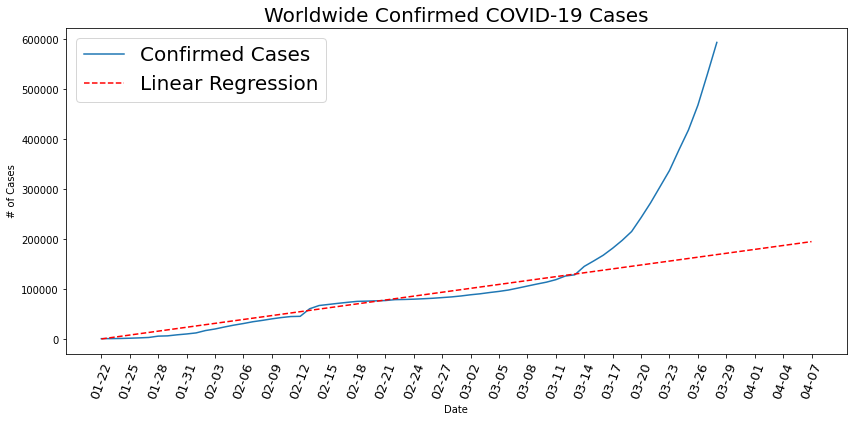

In [11]:
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed)
plt.plot(future_range_dates_short, linear_world_conf_pred, linestyle='dashed', color='red')
plt.title('Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'Linear Regression'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()

## Polynomial Regression

In [12]:
## Worldwide Polynomial Regression
poly_features = PolynomialFeatures(degree=5)
poly_X_train_world_confirmed = poly_features.fit_transform(X_train_world_confirmed)
poly_X_test_world_confirmed = poly_features.fit_transform(X_test_world_confirmed)
poly_future_world_forcast = poly_features.fit_transform(future_range)

poly_reg_model = LinearRegression(normalize=True, fit_intercept=False)
poly_reg_model.fit(poly_X_train_world_confirmed, y_train_world_confirmed)
test_poly_world_conf_pred = poly_reg_model.predict(poly_X_test_world_confirmed)
poly_world_conf_pred = poly_reg_model.predict(poly_future_world_forcast)
mAE_poly_world_conf = mean_absolute_error(y_test_world_confirmed, test_poly_world_conf_pred)
mSE_poly_world_conf = mean_squared_error(y_test_world_confirmed, test_poly_world_conf_pred)
mSLE_poly_world_conf = mean_squared_log_error(y_test_world_confirmed, test_poly_world_conf_pred)
rMSE_poly_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_poly_world_conf_pred))
mAbE_poly_world_conf = median_absolute_error(y_test_world_confirmed, test_poly_world_conf_pred)
mAPE_poly_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_poly_world_conf_pred)
r2_poly_world_conf = r2_score(y_test_world_confirmed, test_poly_world_conf_pred)
mPD_poly_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_poly_world_conf_pred)
mGD_poly_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_poly_world_conf_pred)
mTD_poly_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_poly_world_conf_pred)
mE_poly_world_conf = max_error(y_test_world_confirmed, test_poly_world_conf_pred)
mEVS_poly_world_conf = explained_variance_score(y_test_world_confirmed, test_poly_world_conf_pred)

print('Polynomial Regression on Worldwide Confirmed Cases: ')
print('Mean Absolute Error:', mAE_poly_world_conf)
print('Mean Squared Error:', mSE_poly_world_conf)
print('Mean Squared Log Error:', mSLE_poly_world_conf)
print('Root Mean Squared Error:', rMSE_poly_world_conf)
print('Media Absolute Error:', mAbE_poly_world_conf)
print('Mean Absolute Percentage Error:', mAPE_poly_world_conf)
print('R2 Score:', r2_poly_world_conf)
print('Mean Poisson Deviance:', mPD_poly_world_conf)
print('Mean Gamma Deviance:', mGD_poly_world_conf)
print('Medan Tweedie Deviance:', mTD_poly_world_conf)
print('Max Error:', mE_poly_world_conf)
print('Explained Variance Score:', mEVS_poly_world_conf)

Polynomial Regression on Worldwide Confirmed Cases: 
Mean Absolute Error: 30139.27145664585
Mean Squared Error: 1456910398.7812696
Mean Squared Log Error: 0.0067628677318203965
Root Mean Squared Error: 38169.495657936975
Media Absolute Error: 25027.199476923328
Mean Absolute Percentage Error: 6.858645621558212
R2 Score: 0.8974612023909411
Mean Poisson Deviance: 3138.487819196115
Mean Gamma Deviance: 0.007010692205161195
Medan Tweedie Deviance: 1456910398.7812696
Max Error: 77656.14997165534
Explained Variance Score: 0.9599797673956645


In [13]:
poly_world_conf_pred = poly_world_conf_pred.reshape(1,-1)[0]
print('Polynomial Regression Worldwide Confirmed Cases Future Predictions: ')
set(zip(future_range_dates[-10:], np.round(poly_world_conf_pred[-10:])))

Polynomial Regression Worldwide Confirmed Cases Future Predictions: 


{('2020-03-28', 567935.0),
 ('2020-03-29', 625045.0),
 ('2020-03-30', 687265.0),
 ('2020-03-31', 754911.0),
 ('2020-04-01', 828306.0),
 ('2020-04-02', 907787.0),
 ('2020-04-03', 993703.0),
 ('2020-04-04', 1086410.0),
 ('2020-04-05', 1186282.0),
 ('2020-04-06', 1293702.0)}

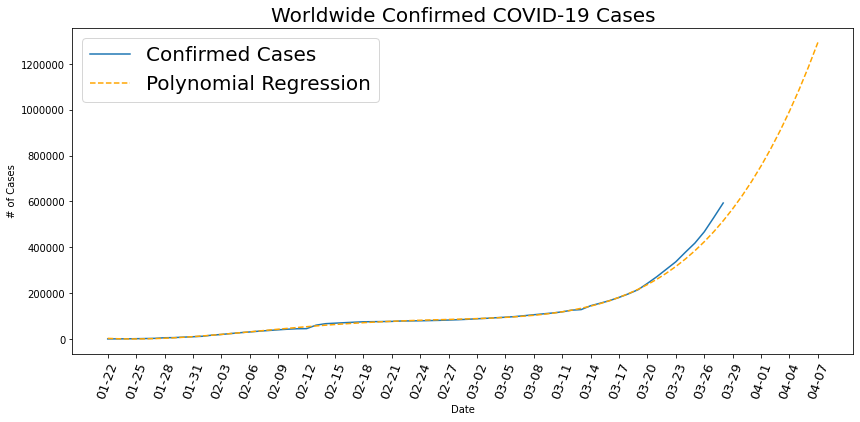

In [14]:
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed)
plt.plot(future_range_dates_short, poly_world_conf_pred, linestyle='dashed', color='orange')
plt.title('Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'Polynomial Regression'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()

In [15]:
## example country

In [16]:
## example state

In [17]:
## example city

## SVM

In [18]:
svm_classifier = svm.SVR()

svm_classifier.fit(poly_X_train_world_confirmed, y_train_world_confirmed)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## K Nearest Neighbors

In [19]:
neighbors_classifier = KNeighborsRegressor(n_neighbors=4)

neighbors_classifier.fit(poly_X_train_world_confirmed, y_train_world_confirmed)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='uniform')

## Bayesian Ridge

In [20]:
covidFilled.groupby(["Date", "Country", "Province_State"])[['Date', 'Province_State', 'Country', 'Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

,Date,Country,Province_State,Confirmed,Deaths,Recovered
0,2020-01-22,Hong Kong,Hong Kong,0.0,0.0,0.0
1,2020-01-22,Macau,Macau,1.0,0.0,0.0
2,2020-01-22,Mainland China,Anhui,1.0,0.0,0.0
3,2020-01-22,Mainland China,Beijing,14.0,0.0,0.0
4,2020-01-22,Mainland China,Chongqing,6.0,0.0,0.0
...,...,...,...,...,...,...
5159,2020-03-27,United Kingdom,Cayman Islands,8.0,1.0,0.0
5160,2020-03-27,United Kingdom,Channel Islands,88.0,1.0,0.0
5161,2020-03-27,United Kingdom,Gibraltar,55.0,0.0,14.0
5162,2020-03-27,United Kingdom,Isle of Man,29.0,0.0,0.0


In [21]:
covidFilled.groupby("Country")[['Confirmed', 'Deaths', 'Recovered']].last().reset_index()

,Country,Confirmed,Deaths,Recovered
0,Azerbaijan,1.0,0.0,0.0
1,Afghanistan,110.0,4.0,2.0
2,Albania,186.0,8.0,31.0
3,Algeria,409.0,26.0,29.0
4,Andorra,267.0,3.0,1.0
...,...,...,...,...
221,Vietnam,163.0,0.0,20.0
222,West Bank and Gaza,91.0,1.0,17.0
223,Zambia,22.0,0.0,0.0
224,Zimbabwe,5.0,1.0,0.0


In [22]:
covidFilled.groupby('Last_Update').sum()[['Confirmed', 'Deaths', 'Recovered']].reset_index()

,Last_Update,Confirmed,Deaths,Recovered
0,2020-01-22 17:00:00,555.0,17.0,28.0
1,2020-01-23 17:00:00,653.0,18.0,30.0
2,2020-01-24 17:00:00,941.0,26.0,36.0
3,2020-01-25 17:00:00,1438.0,42.0,39.0
4,2020-01-26 16:00:00,2118.0,56.0,52.0
...,...,...,...,...
1929,2020-03-27 10:48:42,155.0,3.0,133.0
1930,2020-03-27 22:14:55,101657.0,1581.0,869.0
1931,2020-03-27 23:23:03,401645.0,22252.0,54847.0
1932,2020-03-27 23:27:32,4682.0,54.0,256.0


In [23]:
proph_world_confirmed = covidFilled.groupby('Date').sum()['Confirmed'].reset_index()
proph_world_deaths = covidFilled.groupby('Date').sum()['Deaths'].reset_index()
proph_world_recovered = covidFilled.groupby('Date').sum()['Recovered'].reset_index()
proph_world_confirmed.columns = ['ds','y']
proph_world_confirmed['ds'] = pd.to_datetime(proph_world_confirmed['ds'])
#proph_world_confirmed.head()

proph_m_w_conf = Prophet(interval_width=0.95)
proph_m_w_conf.fit(proph_world_confirmed)
proph_future_world = proph_m_w_conf.make_future_dataframe(periods=7)
proph_future_world_confirmed = proph_future_world.copy()
#proph_future_world.tail()

proph_forecast_w_conf = proph_m_w_conf.predict(proph_future_world)
proph_forecast_w_conf[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
68,2020-03-30,574765.975705,538240.447443,609203.582035
69,2020-03-31,601890.408529,564090.141663,640294.339779
70,2020-04-01,630803.719335,594725.413577,666883.443236
71,2020-04-02,661960.734127,619530.817623,699821.352360
72,2020-04-03,694172.958439,653730.022327,732406.164994


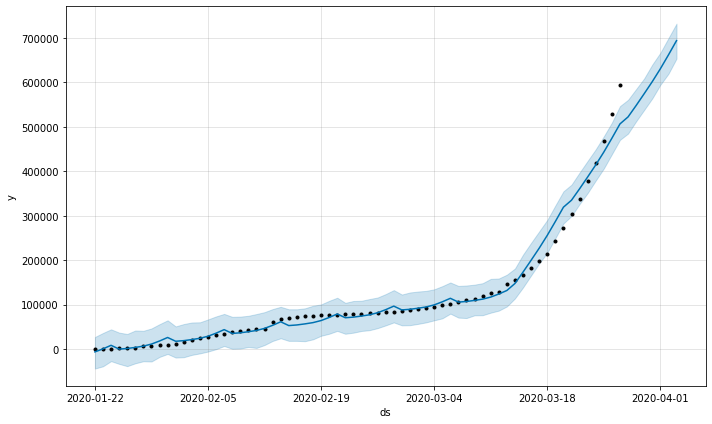

In [24]:
wor_confirmed_forecast_plot = proph_m_w_conf.plot(proph_forecast_w_conf)

In [25]:
## World Confirmed Prophet Evaluation Metrics
df_cv = cross_validation(proph_m_w_conf, initial='60 days', period='3 days', horizon = '5 days')
#df_cv.head()
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-03-22 00:00:00 and 2020-03-22 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,1.098031e+10,104786.980684,104786.980684,0.277004,0.277004,0.0
1,2 days,1.795027e+10,133978.634527,133978.634527,0.320549,0.320549,0.0
2,3 days,2.963933e+10,172160.759417,172160.759417,0.368184,0.368184,0.0
3,4 days,4.910813e+10,221603.552029,221603.552029,0.418443,0.418443,0.0
4,5 days,7.385710e+10,271766.635129,271766.635129,0.458066,0.458066,0.0


In [26]:
proph_world_deaths.columns = ['ds','y']
proph_world_deaths['ds'] = pd.to_datetime(proph_world_deaths['ds'])
proph_m_w_deaths = Prophet(interval_width=0.95)
proph_m_w_deaths.fit(proph_world_deaths)
proph_future_w_deaths = proph_m_w_deaths.make_future_dataframe(periods=7)
proph_future_deaths_w = proph_future_w_deaths.copy()

forecast_deaths_proph_w = proph_m_w_deaths.predict(proph_future_w_deaths)
forecast_deaths_proph_w[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
68,2020-03-30,24140.986518,21757.898406,26561.447378
69,2020-03-31,25322.671279,23089.295962,27759.453911
70,2020-04-01,26594.832027,24316.671650,28980.035954
71,2020-04-02,27756.603984,25305.740089,30158.342020
72,2020-04-03,29033.566569,26471.912803,31360.300880


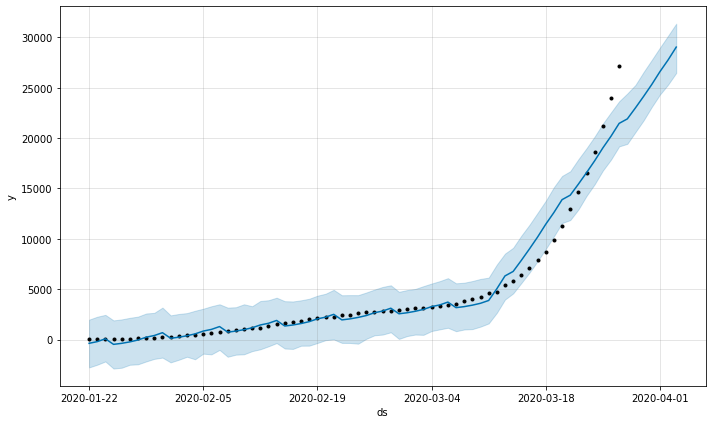

In [27]:
proph_w_deaths_forecast_plot = proph_m_w_deaths.plot(forecast_deaths_proph_w)

In [28]:
df_cv = cross_validation(proph_m_w_deaths, initial='60 days', period='3 days', horizon = '5 days')
#df_cv.head()
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-03-22 00:00:00 and 2020-03-22 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,1.641192e+07,4051.163171,4051.163171,0.245570,0.245570,0.0
1,2 days,3.098484e+07,5566.402548,5566.402548,0.299028,0.299028,0.0
2,3 days,5.570974e+07,7463.895525,7463.895525,0.352386,0.352386,0.0
3,4 days,9.258294e+07,9622.002750,9622.002750,0.401419,0.401419,0.0
4,5 days,1.473770e+08,12139.893547,12139.893547,0.446352,0.446352,0.0


## Florida COVID-19 Case Predictions

In [29]:
proph_flconfirmed = covidFilled.query('Province_State=="Florida"').groupby('Date')[['Confirmed']].sum().reset_index()
proph_fldeaths = covidFilled.query('Province_State=="Florida"').groupby('Date')[['Deaths']].sum().reset_index()
proph_flrecovered = covidFilled.query('Province_State=="Florida"').groupby('Date')[['Recovered']].sum().reset_index()
proph_flconfirmed.columns = ['ds','y']
#flconfirmed['ds'] = flconfirmed['ds'].dt.date
proph_flconfirmed['ds'] = pd.to_datetime(proph_flconfirmed['ds'])
proph_flconfirmed.tail()
#proph_flconfirmed.head()


,ds,y
13,2020-03-23,1227.0
14,2020-03-24,1412.0
15,2020-03-25,1682.0
16,2020-03-26,2357.0
17,2020-03-27,2900.0


In [30]:
fl_m = Prophet(interval_width=0.95)
fl_m.fit(proph_flconfirmed)
fl_future = fl_m.make_future_dataframe(periods=7)
fl_future_confirmed = fl_future.copy()
#fl_future.tail()
fl_forecast = fl_m.predict(fl_future)
fl_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


,ds,yhat,yhat_lower,yhat_upper
20,2020-03-30,2189.591934,1561.872573,2857.587959
21,2020-03-31,2545.763971,1858.784236,3190.023880
22,2020-04-01,2672.755217,1978.208258,3349.929559
23,2020-04-02,2934.411377,2303.156676,3589.340824
24,2020-04-03,3169.067369,2561.965320,3797.621321


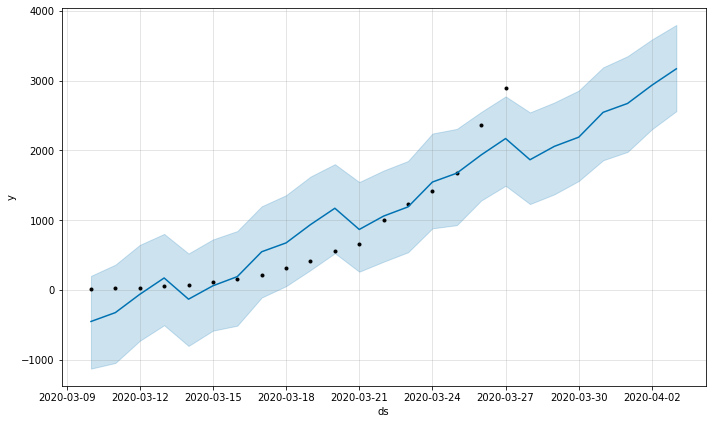

In [31]:
fl_confirmed_forecast_plot = fl_m.plot(fl_forecast)

In [32]:
proph_fldeaths.columns = ['ds','y']
proph_fldeaths['ds'] = pd.to_datetime(proph_fldeaths['ds'])
fl_m = Prophet(interval_width=0.95)
fl_m.fit(proph_fldeaths)
fl_future = fl_m.make_future_dataframe(periods=7)
fl_future_deaths = fl_future.copy() # for non-baseline predictions later on
#fl_future.tail()
fl_forecast = fl_m.predict(fl_future)
fl_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


,ds,yhat,yhat_lower,yhat_upper
20,2020-03-30,29.339891,22.397509,35.820155
21,2020-03-31,32.452545,25.877987,38.813689
22,2020-04-01,34.452788,28.128042,40.715952
23,2020-04-02,37.119645,30.565527,43.593392
24,2020-04-03,39.453150,32.966793,46.031568


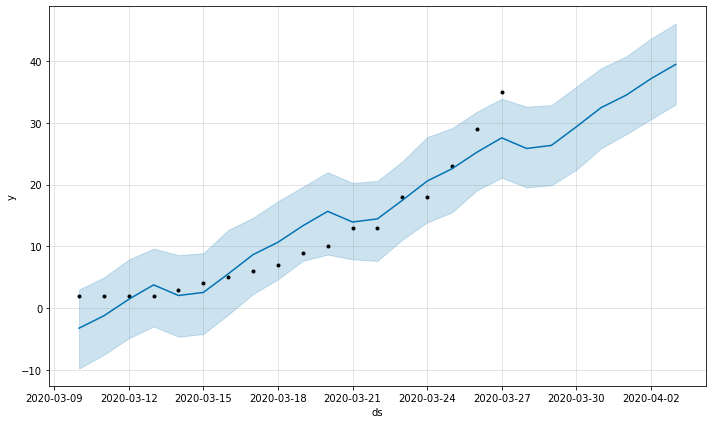

In [33]:
fl_deaths_forecast_plot = fl_m.plot(fl_forecast)

## Combined Evaluation Metrics
#### Results from models throughout this notebook can be seen below:

In [34]:
table = [["World Mean Absolute Err",mAE_linear_world_conf, mAE_poly_world_conf, '...', '...'],
         ["World Mean Squared Err",mSE_linear_world_conf,mSE_poly_world_conf],
         ["World Mean Squared Log Err",mSLE_linear_world_conf,mSLE_poly_world_conf],
         ["World Root Mean Squared Err",rMSE_linear_world_conf,rMSE_poly_world_conf],
         ["World Median Absolute Err",mAbE_linear_world_conf,mAbE_poly_world_conf],
         ["World Mean Absolute Percentage Err",mAPE_linear_world_conf,mAPE_poly_world_conf],
         ["World R2 Score",r2_linear_world_conf,r2_poly_world_conf],
         ["World Mean Poisson Deviance",mPD_linear_world_conf,mPD_poly_world_conf],
         ["World Mean Gamma Deviance",mGD_linear_world_conf,mGD_poly_world_conf],
         ["World Mean Tweedie Deviance",mTD_linear_world_conf,mTD_poly_world_conf],
         ["World Max Error",mE_linear_world_conf,mE_poly_world_conf],
         ["World Explained Variance Score",mEVS_linear_world_conf,mEVS_poly_world_conf],
         ["Country MAE", '...'],
         ["Country MSE",'...']]
headName = ['', 'Linear', 'Polynomial', 'SVM', 'Bayesian']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))

,Linear,Polynomial,SVM,Bayesian
World Mean Absolute Err,218712.88194980705,30139.3,...,...
World Mean Squared Err,60340849307.69255,1.45691e+09,,
World Mean Squared Log Err,0.7509583699548251,0.00676287,,
World Root Mean Squared Err,245643.74469481723,38169.5,,
World Median Absolute Err,200559.18194980704,25027.2,,
World Mean Absolute Percentage Err,54.429131035271915,6.85865,,
World R2 Score,-3.246848769763722,0.897461,,
World Mean Poisson Deviance,245205.50220994372,3138.49,,
World Mean Gamma Deviance,1.0788549035028285,0.00701069,,
World Mean Tweedie Deviance,60340849307.69255,1.45691e+09,,


#### The table above serves to compare the evaluation metrics of each model against different regions and sizes of data. As the same models are applied to different sizes of data sets, the evaluation metrics are compared and show which models have more acceptable errors for those particular data set sizes based on region selected.